# Transforms on Data Part I

Performing transforms on data is a key step to finding the most meaningful information in a dataset. In previous classes, we saw basic transforms, such as selecting data which meets a certain criteria in a data frame using masks, and combining data from multiple data frames. In this class, we will dive into transforms which will help us transform data into its most meaningful form. To understand how data is transformed into its most meaningful form, it helps to start with a goal in mind. By transforming data with a goal in mind, we can evaluate candidate transforms based on whether or not they help us make progress towards our goal. Example goals can be to detect the presence of a weak signal (e.g., to sense an object), to predict a pattern (e.g., the weather), or to discern the presence of one factor despite other distracting factors (e.g., to diagnose a disease).

Note that this is distinct from exploratory data analysis and routine data visualization in which we are simply looking to unpack and understand a dataset. When we apply advanced data transforms, we are often interested in engineering a complex *algorithm* (set of steps to solve a problem) which will help us see patterns in the data that others may not have seen. These patterns, patterns which our transforms can find in the data but others' cannot, are where the real value from data science starts to shine forth. The tools we have equipped ourselves with so far, including the ability to program in Python, using numpy, pandas, and various plotting tools, will enable us to perform these feats of algorithm design.

When we apply this mindset of designing a set of steps to find a pattern in the data that no one else has found before, we can draw a critical parallel to the heart of the scientific method, and the essence of the science of data science. In science, we are constantly making hypothesis based on the environments in which we performed experiments, and then repeating those experiments in different environments to see if our hypotheses hold true. When our hypotheses do not hold true in new environments, we adjust our theories from which they were derived to increase their explanatory power. As we expand and generalize our theories to explain new environments, we come closer to building a complete understanding of the world.

Similarly in data science, we strive to go beyond routine visualization of data to uncover insights in the data that no one else was able to uncover before. We then test those insights on new data, often by using them to build predictive models. When the models fail to predict the new data, we generalize the models to increase their explanatory power, until we develop models which explain the most diverse data with the least specific assumptions. When, through this process, we uncover models that do have unusual amounts of explanatory power, there is value to be found. For example, in curing diseases that haven't been cured before, sensing objects further away than ever before sensed, and automating processes never before automated. To achieve such feats of uniqueness, we require unique tools in our tool box. Our transforms, and the combinations of transforms we choose to apply, are these tools.

We will cover some of these tools for transforming data here, and more later this semester. The transforms covered here include the following.

### Correlation

* Multiplication as a detection process
* The matched filter
* Introduction to integral transforms

### Integral Transforms

* The Fourier Transform
* Additional transforms, including spectrograms, Hilbert, Abel and Mellin, may be covered later in the semester as special topics.

### Linear Transforms

* Projection
* Principal Component Analysis

### Basic Nonlinear Transforms

* Logarithmic scaling
* Compression
* Expansion
* Clipping

### Next Steps

These tools will equip us to understand several key topics later in the semester, including the use of fitting models as a data transformation (e.g., Fourier and Polynomial methods for interpolation) and how neural networks can find patterns in data so effectively. Most importantly, the transforms covered here actually give us all the key building blocks required to understand neural networks from the ground up.

## Preliminaries

Before we start, we will need some basic tools. The main motivation for data transformation is to combat noise. The heart of data transformation is exploiting redundancy in our data to sense patterns despite the presence of noise which might appear to mask those patterns. We seek to combine the right parts of our data so that noise terms cancel as much as possible and so that the interesting data elements, i.e., those that contribute to our goals, combine in ways that shine through the noise to become apparent to us, and to other algorithms which might need to draw autonomous conclusions from that data.

To study noisy data in this notebook, we introduce a simple noise adding function. This function accepts an array of a given size and adds noise from a gaussian distribution to that array. The function allows us to specify the signal to noise ratio (SNR) in decibels. The SNR for a signal $x[n]$ and noise $\eta[n]$ is defined as follows.

$$
\mathrm{SNR} = P_x / P_{\eta}
$$

Here $P$ is the power of the signal.

$$
P_{x} = \frac{1}{N} \sum_{n=1}^N x^2[n] \\
P_{\eta} = \frac{1}{N} \sum_{n=1}^N \eta^2[n] = \sigma^2
$$

For zero-mean, normally distributed $\eta$, noise power is equal to variance, i.e., $P_{\eta} = \sigma^2$.

We will also need pulsed tone signals. Our pulsed tone signals will take the following form. Using a definition in continuous time, we have

$$
x(t) = (\theta(t - T_{S}) - \theta(t - T_{E})) \sin(2 \pi f t)
$$

Here, $\theta(t)$ represents the heaviside step, such that the tone turns on at time $T_S$ and turns off at time $T_E$.

For those familiar with Nyquist sampling, we will sample above Nyquist rate throughout these notebooks to make some plots clearer.

We import functions for adding Gaussian noise and for generating pulse tone signals from a module outside this notebook.

[Text(0.5, 0, 'Time (ms)'),
 Text(0, 0.5, 'Voltage (mV)'),
 Text(0.5, 1.0, '440 Hz Tone with -20 dB SNR')]

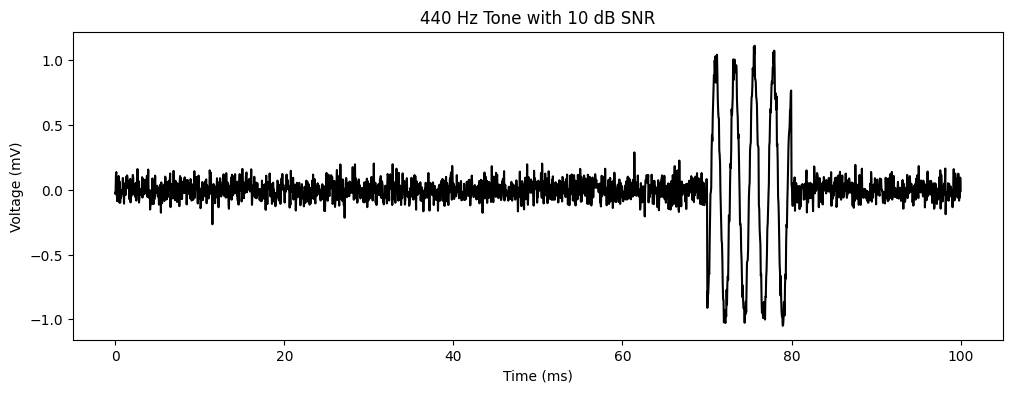

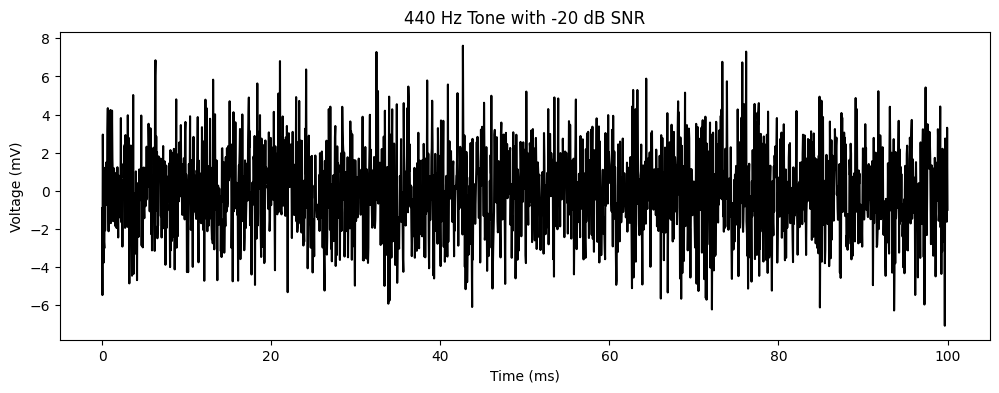

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from signal_tools import add_white_gaussian_noise, generate_tone_signal

# Setup
SEC_TO_MSEC = 1e3
rng_seed = 1000
rng = np.random.default_rng(rng_seed)
end_time_seconds = 0.1
pulse_start_seconds = 0.07
pulse_end_seconds = 0.08
frequency1_hz = 440

# Generate a signal - sample well above Nyquist
sampling_frequency = frequency1_hz * 50
sampling_time_seconds = 1 / sampling_frequency
time_seconds = np.arange(0, end_time_seconds, sampling_time_seconds)

tone_signal = generate_tone_signal(
    time_seconds, pulse_start_seconds, pulse_end_seconds, frequency1_hz
)

# Add noise
snr_db = 10
noisy_signal = add_white_gaussian_noise(tone_signal, snr_db, rng)

# Plot the result
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(time_seconds * SEC_TO_MSEC, noisy_signal, color="k")
ax.set(
    xlabel="Time (ms)",
    ylabel="Voltage (mV)",
    title=f"440 Hz Tone with {snr_db} dB SNR",
)

# Add more noise
snr_db = -20
very_noisy_signal = add_white_gaussian_noise(tone_signal, snr_db, rng)

# Plot the result
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(time_seconds * SEC_TO_MSEC, very_noisy_signal, color="k")
ax.set(
    xlabel="Time (ms)",
    ylabel="Voltage (mV)",
    title=f"440 Hz Tone with {snr_db} dB SNR",
)

## Correlation

### Multiplication Example

Here we introduce correlation as a means of detecting patterns. We begin by using multiplication to find a pattern in some data.

In [2]:
x_signal = np.array(
    [
        0,
        0,
        0,
        0,
        0,
        1,
        0,
        1,
        0,
        1,
        0,
        0,
        0,
        0,
        0,
    ]
)
template = np.array([1, 0, 1, 0, 1])

x_len = x_signal.shape[0]
t_len = template.shape[0]

valid_len = x_len - t_len + 1

products = []
summations = np.zeros((valid_len,))

for index in range(valid_len):
    equal_length_snippet_of_x_signal = x_signal[index : index + (t_len)]
    product = template * equal_length_snippet_of_x_signal
    sum_of_product = np.sum(product)

    # Keep track of intermediate results to understand the algorithm
    products.append(product)
    summations[index] = sum_of_product

In [3]:
# Inspect and see where the sum of the element-wise products will be high
products

[array([0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 1]),
 array([0, 0, 0, 0, 0]),
 array([0, 0, 1, 0, 1]),
 array([0, 0, 0, 0, 0]),
 array([1, 0, 1, 0, 1]),
 array([0, 0, 0, 0, 0]),
 array([1, 0, 1, 0, 0]),
 array([0, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0])]

[Text(0.5, 0, 'Sample'),
 Text(0, 0.5, 'Sum of Products'),
 Text(0.5, 1.0, 'Peak Indicates Pattern Location')]

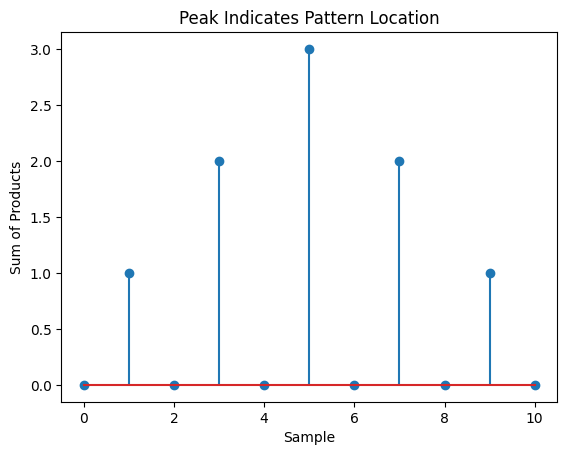

In [4]:
fig, ax = plt.subplots()
ax.stem(summations)
ax.set(
    xlabel="Sample",
    ylabel="Sum of Products",
    title="Peak Indicates Pattern Location",
)

### Using Numpy

We can use NumPy to perform this same function for us, implementing the signal processing definition of the cross-correlation via the [correlate](https://numpy.org/doc/stable/reference/generated/numpy.correlate.html) function.

Cross-correlation is defined on real-numbers as

$$
c[k] = \sum_{n} f[n+k] g[n]
$$

where the result $c$ has length

$$
L = L_g - L_f + 1.
$$

Here $L_g$ and $L_f$ are the lengths of $g$ and $f$ respectively. It is assumed $L_f < L_g$ and the $f$ is zero padded to match the length of $g$.


[Text(0.5, 0, 'Sample'),
 Text(0, 0.5, 'Sum of Products'),
 Text(0.5, 1.0, 'Peak Indicates Pattern Location')]

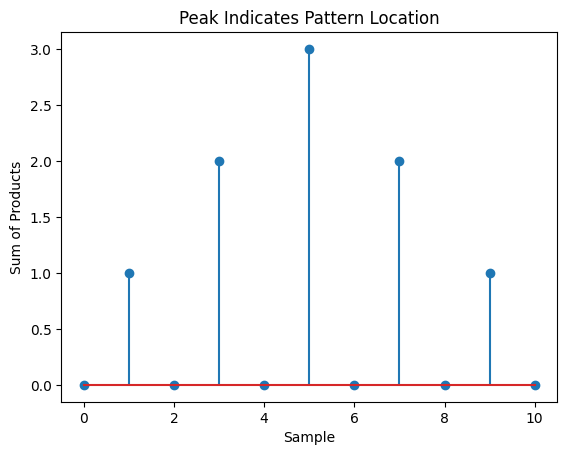

In [5]:
correlation_result = np.correlate(x_signal, template, mode="valid")

fig, ax = plt.subplots()
ax.stem(correlation_result)
ax.set(
    xlabel="Sample",
    ylabel="Sum of Products",
    title="Peak Indicates Pattern Location",
)

## Applying Correlation to Pull Data Out of the Noise!



[Text(0.5, 0, 'Time (ms)'),
 Text(0, 0.5, 'Voltage (mV)'),
 Text(0.5, 1.0, 'Template Pulse')]

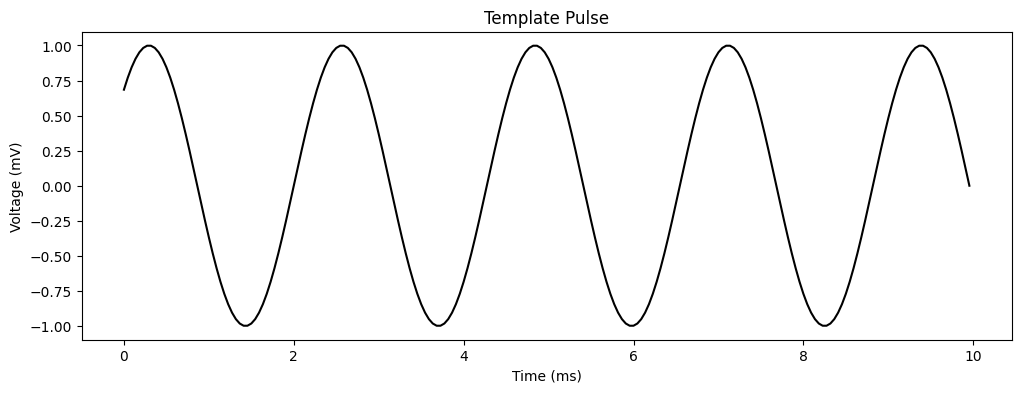

In [6]:
# Construct a Template Tone
pulse_length_seconds = pulse_end_seconds - pulse_start_seconds
template_time = time_seconds[time_seconds < pulse_length_seconds]
tone_template = np.sin(2 * np.pi * frequency1_hz * template_time)

# Time reverse the template
tone_template = tone_template[::-1]

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(template_time * SEC_TO_MSEC, tone_template, color="k")
ax.set(
    xlabel="Time (ms)",
    ylabel="Voltage (mV)",
    title="Template Pulse",
)

[Text(0.5, 0, 'Sample'),
 Text(0, 0.5, 'Sum of Products'),
 Text(0.5, 1.0, 'Peak Indicates Pattern Location')]

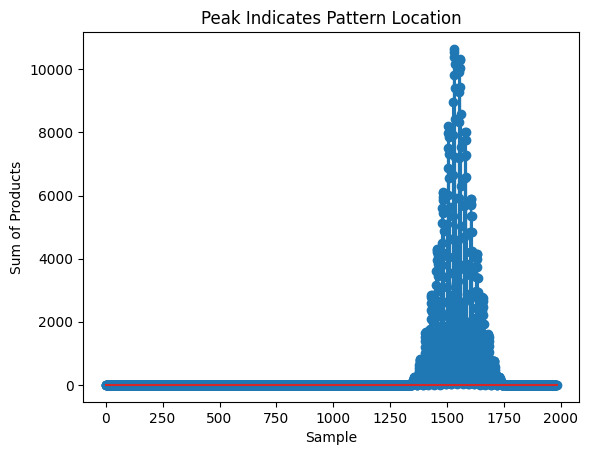

In [7]:
# Detect the Tone in Noise
tone_detection_output = np.correlate(noisy_signal, tone_template)

fig, ax = plt.subplots()
ax.stem(tone_detection_output**2)
ax.set(
    xlabel="Sample",
    ylabel="Sum of Products",
    title="Peak Indicates Pattern Location",
)

[Text(0.5, 0, 'Sample'),
 Text(0, 0.5, 'Sum of Products'),
 Text(0.5, 1.0, 'Peak Indicates Pattern Location')]

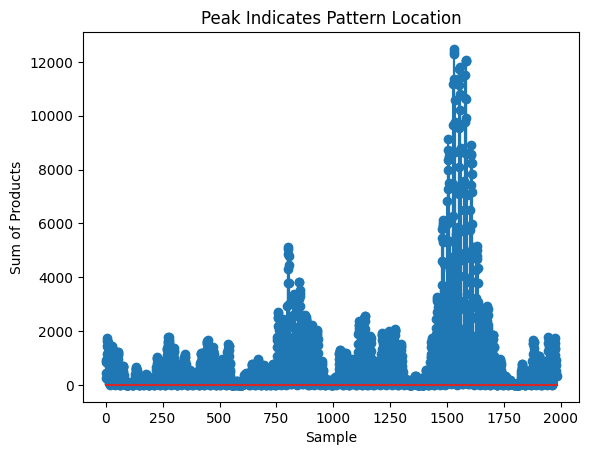

In [8]:
# Detect the Tone in Heavy Noise!
tone_detection_output = np.correlate(very_noisy_signal, tone_template)

fig, ax = plt.subplots()
ax.stem(tone_detection_output**2)
ax.set(
    xlabel="Sample",
    ylabel="Sum of Products",
    title="Peak Indicates Pattern Location",
)